In [1]:
from typing import Callable, List, Tuple

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from torch import nn
from torch.distributions.distribution import Distribution
from pytorch_lightning.loggers import TensorBoardLogger


In [2]:
import torch
from torch import nn
import numpy as np

class L(nn.Linear):
    def __init__(self,n):
        super().__init__(n*(n+1)//2,1,bias=False)
        self.n=n
        self.diag_mask=torch.tensor([ (k+1) * (k+2) // 2 - 1 for k in range(n)])
        self.mask2d=torch.zeros((n*(n+1) // 2),dtype=int)
        for i in range(n):
            for j in range(i+1):
                self.mask2d[i*(i+1)//2+j]=i*n+j
    
    def anti_flatten(self):
        n=self.n
        L=torch.zeros((n**2))
        L[self.mask2d]=self.weight
        L=torch.reshape(L,(n,n))
        return L        
            
    def log_abs_det(self):
        diag=self.weight[0][self.diag_mask]
        la=torch.log(torch.abs(diag))
        lad=torch.sum(la)
        return lad
    
    def forward(self,x):
        Lwt=torch.t(self.anti_flatten())
        return torch.matmul(x,Lwt)
        
    def adj(self,mat):
        Lw=self.anti_flatten()
        Lwt=torch.t(Lw)
        D=torch.matmul(Lwt,torch.matmul(mat,Lw))
        return D

In [3]:
model=L(10)
print(model.anti_flatten())

tensor([[-0.0130,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0567,  0.0085,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0800, -0.0843, -0.0185,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.0374, -0.0562,  0.0279,  0.0439,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1248, -0.0698, -0.0303,  0.0636, -0.0598,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000],
        [-0.0238, -0.0660, -0.0063,  0.1263,  0.0398,  0.0449,  0.0000,  0.0000,
          0.0000,  0.0000],
        [ 0.1027, -0.0903, -0.0308, -0.1165, -0.0109,  0.0800,  0.0200,  0.0000,
          0.0000,  0.0000],
        [ 0.0766, -0.0043,  0.0193, -0.1127,  0.1227, -0.1248, -0.0153,  0.0994,
          0.0000,  0.0000],
        [ 0.0210,  0.1242, -0.1073,  0.0644,  0.0475, -0.0046, -0.0202,  0.0832,
         -0.0859,  0.0000],
        [ 0.0778,  

In [4]:
from NFconstants import N_nod, beta , N_traj
from NFandist import get_A, get_C
A=torch.tensor(get_A(N_nod,beta)).float()
def set_random_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

def A_I(model):
    with torch.no_grad():
        A_D=model.adj(A)
        I=torch.eye(N_nod)
    return torch.linalg.matrix_norm(A_D-I)

In [5]:
class Action(nn.Module):
    def __init__(self,A):
        super().__init__()
        self.A=A
    
    def forward(self,x):
        y=torch.matmul(self.A,x)
        return 1/2 * torch.dot(y,x) 

class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, act, model):
        loss=0
        M=len(x)
        for i in range(M):
            loss+=act(x[i])
        loss=loss/M
        lad=model.log_abs_det()
        loss=loss-lad
        return loss


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 152.54it/s]


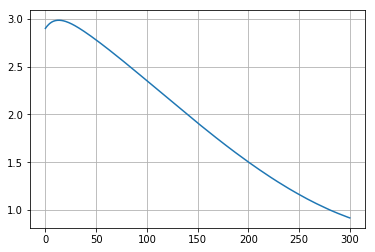

In [6]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from NFconstants import N_nod, beta , N_traj
from NFandist import get_A, get_C
from tqdm import tqdm
import random
from Data import train_loader
from LOSS import KL_osc


set_random_seed(42)    
model=L(N_nod)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = KL_osc
num_epochs=300
metric2=[A_I(model)]


for epoch in tqdm(range(num_epochs)):
    for x in train_loader:
        # Forward pass
        outputs = model(x)
        loss = loss_fn(outputs,model.log_abs_det())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    metric2.append(A_I(model))


fig=plt.figure()
plt.plot(list(range(num_epochs+1)),metric2)
plt.grid(True)
plt.show()


In [ ]:
from LOSS import KL_osc
from Data import train_loader

set_random_seed(42)
L_layer=L(N_nod)
pipeline=Pipeline(model=L_layer,criterion=KL_osc)
trainer = pl.Trainer(
    max_epochs=200,
    logger=TensorBoardLogger(save_dir=f"logs/nf"),
    num_sanity_val_steps=0,
)

trainer.fit(model=pipeline, train_dataloaders=train_loader)
torch.save(nf.state_dict(), "model_weights1.pth")